##  Imports

In [3]:
%run imports.py

Succesfully imported libraries and modules



In [2]:
import numpy as np
import pandas as pd

#!pip install pyEDFlib
import pyedflib
#!pip install ipympl

from scipy.fftpack import fft, ifft, fftfreq
from scipy import signal as sg
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter
from scipy.stats import binned_statistic, entropy, norm
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import sys
import os
import time
#import pickle
import dill as pickle

import concurrent.futures
from numba import jit, njit, prange

from tqdm.notebook import tqdm
from collections import defaultdict
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
#from IPython.display import display
sns.set(context='notebook', style='ticks', palette='bright', font='sans-serif', font_scale=1, color_codes=True, rc=None)
plt.rcParams['figure.figsize'] = (14, 8)

#print("SYS.PATH: ", sys.path[:3])
#sys.path.insert(0, r"C:\Users\User\[[Python]]\[AlexeyT]\PAC_PROJECT")

from utility_functions import *
#from class_lfp import LFP
#from class_pac import MyPAC
#from class_patient import Patient
%run utility_functions.py
%run lfp_class.py
%run pac_class.py
%run patient_class.py

print("Succesfully imported libraries and modules\n")

Succesfully imported libraries and modules



## Pink Noise & Surrogates

In [ ]:
# 3 minutes

sf = 2000
segment_duration = 90
timepoints = np.arange(segment_duration * sf)/sf
noiselevel = 50


x1 = generate_coupled_signal(10, 250, 0.2, 0.1, 0.2, timepoints, noiselevel, noise_type='pink', alpha=1)
x2 = generate_coupled_signal(25, 350, 0.1, 0.05, 0.1, timepoints, noiselevel, noise_type='pink', alpha=1)

x = np.hstack((x1, x2))

lfp_double_pac = LFP(x, 2000, patient_name="Surrogate", condition="Test")

lfp_double_pac.show_spectra(show_freqs=[1, 200])

In [ ]:
p = MyPAC(beta_params=(5, 49, 1, 3), hfo_params=(40, 500, 20, 0), use_numba=True)

In [ ]:
p.filter_fit_pac(lfp_double_pac)

In [ ]:
p.comodulogram(smooth=True)

In [ ]:
p.filter_fit_surrogates(lfp_double_pac, n_splits=1, n_surrogates=200)

In [ ]:
vmax = 0.001

p.comodulogram(smooth=True, vmax=vmax)
plt.show()
p.comodulogram(significant=True, correction='None', smooth=True, vmax=vmax)
plt.show()
p.comodulogram(significant=True, correction='Multiple', smooth=True, vmax=vmax)
plt.show()

In [ ]:
# 1 minute

sf = 2000
segment_duration = 30
timepoints = np.arange(segment_duration * sf)/sf
noiselevel = 50


x1 = generate_coupled_signal(10, 250, 0.2, 0.1, 0.2, timepoints, noiselevel, noise_type='pink', alpha=1)
x2 = generate_coupled_signal(25, 350, 0.1, 0.05, 0.1, timepoints, noiselevel, noise_type='pink', alpha=1)

x = np.hstack((x1, x2))

lfp_double_pac = LFP(x, 2000, patient="Surrogate", condition="Test")

lfp_double_pac.condition += str(segment_duration * 2)

lfp_double_pac.show_spectra(show_freqs=[1, 200])

In [ ]:
p = MyPAC(beta_params=(5, 35, 1, 3), hfo_params=(50, 500, 25, 0))

In [ ]:
p.filter_fit_pac(lfp_double_pac)

In [ ]:
p.comodulogram(smooth=True)

In [ ]:
p.filter_fit_surrogates(lfp_double_pac)

In [ ]:
vmax = 0.001

p.comodulogram(smooth=True, vmax=vmax)
plt.show()
p.comodulogram(significant=True, correction='None', smooth=True, vmax=vmax)
plt.show()
p.comodulogram(significant=True, correction='Multiple', smooth=True, vmax=vmax)
plt.show()

In [ ]:
plt.hist(surrogate_pac_matrices[:, 0, 10])

In [ ]:
for j in range(3, 7):

    p.comodulogram(surrogate_pac_matrices[j])
    plt.show()

In [ ]:
p.pac_matrix = surrogate_pac_matrices.mean(axis=0)

p.comodulogram()

plt.show()

p.filter_fit_pac(lfp_double_pac)

p.comodulogram()
plt.show()

In [ ]:
pac = MyPAC(beta_params=(5, 35, 1, 3), hfo_params=(50, 500, 25, 0))

pac.filter_fit_pac(lfp_double_pac)

In [ ]:
beta = np.arange(5, 36, 1)
hfo = np.arange(50, 525, 25)

X, Y = np.meshgrid(beta, hfo)

plt.contourf(X, Y, pac.pac_matrix, levels=20, alpha=1)

### Signal Simulation formula from Tort et. al

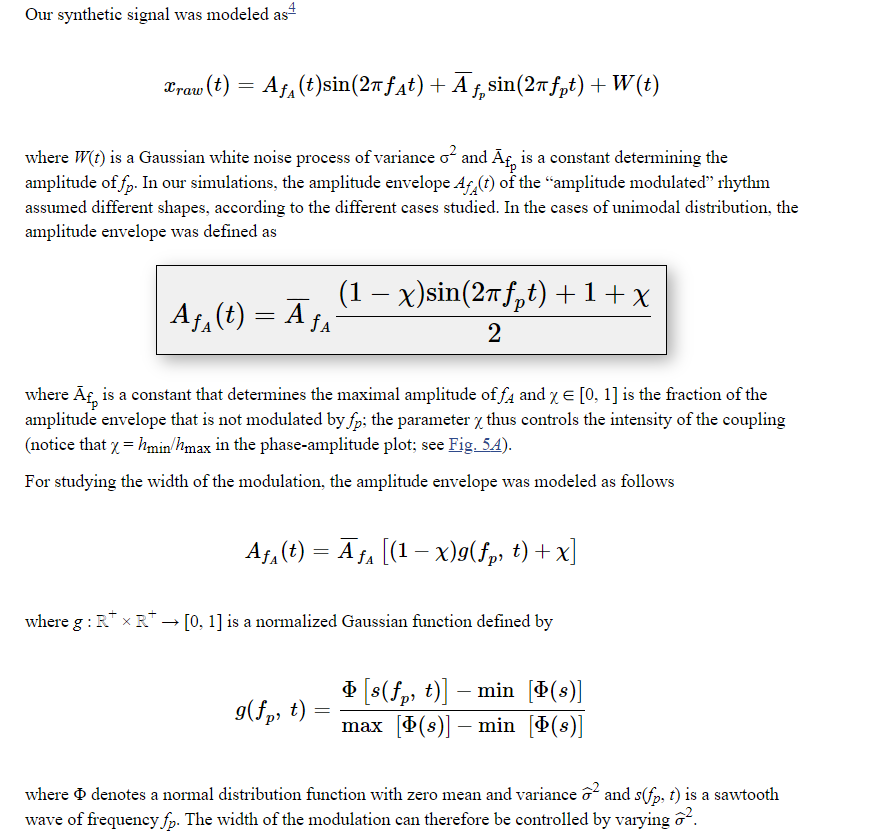

## Patient 1. LFP extraction and PAC analysis

In [ ]:
p1 = Patient(name='Patient1', root_dir=r"H:\Alexey_Timchenko\PAC\Patient1")
files = p1.find_bdf_files()
for filename in files:
    p1.scan_file_annotations(filename, update_file_conditions=True)

In [ ]:
p1.display_all_annotations()

In [ ]:
p1.get_preprocessed_lfps(verbose=False)

In [ ]:
for file in p1.files:
    p1.scan_file_annotations(file)

### Creating 180 sec LFPs

In [ ]:
# Here WE CREATE NEW CONDITIONS:
# 1Day OFF Rest / RH / LH movement 180sec
# 1Day ON Rest / RH / LH movement 180sec

# Same for 5Day

sf = 2000

prefix = "1Day OFF "
new_condition = "Rest 180sec"
for placement in p1.placements:
    lfp = p1.lfp[prefix + "Rest"][placement]
    new_lfp = LFP(lfp.data[:180*sf], patient_name=p1.name, condition=prefix+new_condition, placement=placement)
    p1.add_lfp(new_lfp)
    
prefix = "1Day ON "
new_condition = "Rest 180sec"
for placement in p1.placements:
    lfp = p1.lfp[prefix + "Rest"][placement]
    new_lfp = LFP(lfp.data, patient_name=p1.name, condition=prefix+new_condition, placement=placement)
    p1.add_lfp(new_lfp)


prefix = "1Day OFF "
new_condition = "RH Move 180sec"
for placement in p1.placements:
    lfp1 = p1.lfp[prefix + "RH (Com)"][placement]
    lfp2 = p1.lfp[prefix + "RH (NoCom)"][placement]
    lfp3 = p1.lfp[prefix + "RH (Hold)"][placement]
    lfp4 = p1.lfp[prefix + "RH (Pass)"][placement]
    new_data = np.concatenate((lfp1.data, lfp2.data, lfp3.data, lfp4.data))
    new_lfp = LFP(new_data, patient_name=p1.name, condition=prefix+new_condition, placement=placement)
    p1.add_lfp(new_lfp)
    
prefix = "1Day OFF "
new_condition = "LH Move 180sec"
for placement in p1.placements:
    lfp1 = p1.lfp[prefix + "LH (Com)"][placement]
    lfp2 = p1.lfp[prefix + "LH (NoCom)"][placement]
    lfp3 = p1.lfp[prefix + "LH (Hold)"][placement]
    lfp4 = p1.lfp[prefix + "RHLH"][placement]
    new_data = np.concatenate((lfp1.data, lfp2.data, lfp3.data, lfp4.data))
    new_lfp = LFP(new_data, patient_name=p1.name, condition=prefix+new_condition, placement=placement)
    p1.add_lfp(new_lfp)
    
prefix = "1Day ON "
new_condition = "RH Move 180sec"
for placement in p1.placements:
    lfp1 = p1.lfp[prefix + "RH (Com)"][placement]
    lfp2 = p1.lfp[prefix + "RH (NoCom)"][placement]
    lfp3 = p1.lfp[prefix + "RH (Hold)"][placement]
    lfp4 = p1.lfp[prefix + "RH (Pass)"][placement]
    new_data = np.concatenate((lfp1.data, lfp2.data, lfp3.data, lfp4.data))
    new_lfp = LFP(new_data, patient_name=p1.name, condition=prefix+new_condition, placement=placement)
    p1.add_lfp(new_lfp)
    
prefix = "1Day ON "
new_condition = "LH Move 180sec"
for placement in p1.placements:
    lfp1 = p1.lfp[prefix + "LH (Com)"][placement]
    lfp2 = p1.lfp[prefix + "LH (NoCom)"][placement]
    lfp3 = p1.lfp[prefix + "LH (Hold)"][placement]
    lfp4 = p1.lfp[prefix + "LH (Pass)"][placement]
    new_data = np.concatenate((lfp1.data, lfp2.data, lfp3.data, lfp4.data))
    new_lfp = LFP(new_data, patient_name=p1.name, condition=prefix+new_condition, placement=placement)
    p1.add_lfp(new_lfp)
    

""" ----------5DAY------------"""

# in OFF 300 seconds - shrink it to 180 seconds
prefix = "5Day OFF "
new_condition = "Rest 180sec"
for placement in p1.placements:
    lfp = p1.lfp[prefix + "Rest"][placement]
    new_lfp = LFP(lfp.data[:180*sf], patient_name=p1.name, condition=prefix+new_condition, placement=placement)
    p1.add_lfp(new_lfp)
    
prefix = "5Day ON "
new_condition = "Rest 180sec"
for placement in p1.placements:
    lfp = p1.lfp[prefix + "Rest"][placement]
    new_lfp = LFP(lfp.data, patient_name=p1.name, condition=prefix+new_condition, placement=placement)
    p1.add_lfp(new_lfp)


prefix = "5Day OFF "
new_condition = "RH Move 180sec"
for placement in p1.placements:
    lfp1 = p1.lfp[prefix + "RH (Com)"][placement]
    lfp2 = p1.lfp[prefix + "RH (NoCom)"][placement]
    lfp3 = p1.lfp[prefix + "RH (Hold)"][placement]
    lfp4 = p1.lfp[prefix + "RH (Pass)"][placement]
    new_data = np.concatenate((lfp1.data, lfp2.data, lfp3.data, lfp4.data))
    new_lfp = LFP(new_data, patient_name=p1.name, condition=prefix+new_condition, placement=placement)
    p1.add_lfp(new_lfp)
    
prefix = "5Day OFF "
new_condition = "LH Move 180sec"
for placement in p1.placements:
    lfp1 = p1.lfp[prefix + "LH (Com)"][placement]
    lfp2 = p1.lfp[prefix + "LH (NoCom)"][placement]
    lfp3 = p1.lfp[prefix + "LH (Hold)"][placement]
    lfp4 = p1.lfp[prefix + "LH (Pass)"][placement]
    new_data = np.concatenate((lfp1.data, lfp2.data, lfp3.data, lfp4.data))
    new_lfp = LFP(new_data, patient_name=p1.name, condition=prefix+new_condition, placement=placement)
    p1.add_lfp(new_lfp)
    
prefix = "5Day ON "
new_condition = "RH Move 180sec"
for placement in p1.placements:
    lfp1 = p1.lfp[prefix + "RH (Com)"][placement]
    lfp2 = p1.lfp[prefix + "RH (NoCom)"][placement]
    lfp3 = p1.lfp[prefix + "RH (Hold)"][placement]
    lfp4 = p1.lfp[prefix + "RH (Pass)"][placement]
    new_data = np.concatenate((lfp1.data, lfp2.data, lfp3.data, lfp4.data))
    new_lfp = LFP(new_data, patient_name=p1.name, condition=prefix+new_condition, placement=placement)
    p1.add_lfp(new_lfp)
    
prefix = "5Day ON "
new_condition = "LH Move 180sec"
for placement in p1.placements:
    lfp1 = p1.lfp[prefix + "LH (Com)"][placement]
    lfp2 = p1.lfp[prefix + "LH (NoCom)"][placement]
    lfp3 = p1.lfp[prefix + "LH (Hold)"][placement]
    lfp4 = p1.lfp[prefix + "LH (Pass)"][placement]
    new_data = np.concatenate((lfp1.data, lfp2.data, lfp3.data, lfp4.data))
    new_lfp = LFP(new_data, patient_name=p1.name, condition=prefix+new_condition, placement=placement)
    p1.add_lfp(new_lfp)
    
    
    


### Saving object

In [ ]:
p1_pickle_filepath = p1.save()

### Retrieving object from pickle

In [ ]:
%%time

p1_pickle_filepath = "H:\Alexey_Timchenko\PAC\Patient1\Patient1.pkl"
with open(p1_pickle_filepath, 'rb') as file:
    p1 = pickle.load(file, pickle.HIGHEST_PROTOCOL)

In [ ]:
p1.pac = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

### PAC Calculation

In [ ]:
p1.placements

#### ONE PAC CALC AND SAVING TEST

In [ ]:
condition = "1Day OFF Rest 180sec"
placement = "L2C-3C"

lfp = p1.lfp[condition][placement]
pac = MyPAC(beta_params=(5, 35, 1, 2), hfo_params=(50, 500, 50, 0))
pac.filter_fit_surrogates(lfp, n_surrogates=20, n_splits=3) # try 500 later
pac.save(patient_dir=p1.root_dir)

In [ ]:
filepath = pac.save(patient_dir=p1.root_dir)

with open(filepath, 'rb') as f:
    new_pac = pickle.load(f)

new_pac.comodulogram(significant=True, smooth=False)


## Comodulogram using imshow

In [24]:
pac_root_dir = os.path.join(data_dir, "Patient2", "pac")

test_pac_fname = os.path.join(pac_root_dir, "PAC_Patient2_1Day OFF Rest 180sec_L1-2A_L1-2A_180.0 sec.pkl")

with open(test_pac_fname, 'rb') as _input:
    pac = pickle.load(_input)

In [15]:
 def comodulogram(pac_matrix,
                  beta_params,
                  hfo_params,
                  pvalues=None, 
                  significant=False, 
                  correction='None', 
                  smooth=True, 
                  sigma=1, 
                  vmax=None, 
                  ax=None, 
                  savefig=False):
        
    if significant and pvalues is None:
        raise ValueError("pvalues are necessary to show significant values")

    if significant:

        if correction == 'None':
            zero_indeces = pvalues > 0.01

        if correction == 'Multiple':

            pvalues = pvalues.copy().flatten()
            pvalues_shape = pvalues.shape

            reject, pvalues_corrected, _, _ = multipletests(pvalues) # default Holm-Sidak method

            # if we reject null-hypothesis, that is PAC is confirmed to be significant - padding zero everything else

            reject = reject.reshape(pvalues_shape)
            pvalues_corrected = pvalues_corrected.reshape(pvalues_shape)

            zero_indeces = True ^ reject # XOR inverts boolean array, True if (True ^ False) and False if (True ^ True)

        pac_matrix[zero_indeces] = 0     

    f1, f2, step, bw = beta_params
    xticks = np.arange(f1, f2 + step, step)

    f1, f2, step, bw = hfo_params
    yticks = np.arange(f1, f2 + step, step)

    interpolation = 'gaussian' if smooth else 'none'
    
    imshow_kwargs = {'origin': 'lower', 
                     'cmap': plt.cm.jet, 
                     'aspect': 'auto', 
                     'interpolation': interpolation, 
                     'vmax': vmax, 
                     'extent': [min(xticks) , max(xticks), min(yticks) ,max(yticks)]
                    }
    
    if ax is None:
        im = plt.imshow(pac_matrix, **imshow_kwargs)
    
    else:
        im = ax.imshow(pac_matrix, **imshow_kwargs)

        
        

    #plt.title(f"PAC ({self.method}); {self.patient_name} ; {self.condition}; \n [Phase] {self.phase_placement} ->  [Amplitude] {self.amplitude_placement}")
    # if savefig:
    #     filename = self.name + '.png'
    #     im_dir = os.path.join(self.root_dir, 'im')
    #     try:
    #         os.mkdir(im_dir)
    #     except OSError:
    #         pass
    #     plt.savefig(os.path.join(im_dir, filename))
    
    return im

## Patient 1

### Preprocessing (OPTIONAL)

In [6]:
#%run p1_preprocessing.py

### Loading Patient and PACs from pickle

In [2]:
with open("path_data.txt") as f:
    data_dir = f.readline()

p1_dir = os.path.join(data_dir, "Patient1")
print("Patient directory: ", p1_dir)
p1_pickle_filepath = os.path.join(p1_dir, "Patient1.pkl")

p1 = load_patient_from_pickle(p1_pickle_filepath)

p1.root_dir = p1_dir

Patient directory:  C:\Users\aleks\[[Python]]\LAB\data\Patient1


In [4]:
p1 = load_patient(1)

Patient directory:  D:\LAB\AlexPAC\data\Patient1


In [5]:
p1.pac.keys()

dict_keys(['1Day OFF LH Move 180sec', '1Day OFF Rest 180sec', '1Day OFF RH Move 180sec', '1Day ON LH Move 180sec', '1Day ON Rest 180sec', '1Day ON RH Move 180sec', '5Day OFF LH Move 180sec', '5Day OFF Rest 180sec', '5Day OFF RH Move 180sec', '5Day ON LH Move 180sec', '5Day ON Rest 180sec', '5Day ON RH Move 180sec'])

### Disrtibution of LFP stds and maximal values

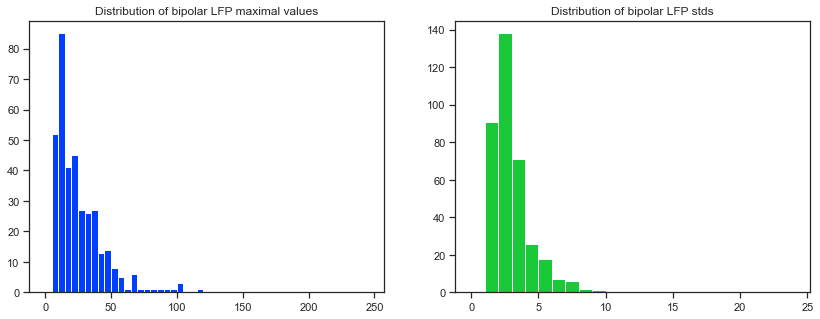

In [6]:
%matplotlib inline

max_list = []
std_list = []

for placement in p1.placements:
    for condition in p1.conditions:
        if '180sec' in condition:
            lfp = p1.lfp[condition][placement]
            max_list.append(np.max(lfp.data))
            std_list.append(np.std(lfp.data))
    
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.set_title("Distribution of bipolar LFP maximal values")      
ax.hist(max_list, bins=np.arange(0, 250, 5))

ax = axes[1]
ax.set_title("Distribution of bipolar LFP stds")      
ax.hist(std_list, bins=np.arange(0, 25, 1), color='g')

plt.show()

## One-electrode (diagonal) PAC

#### Spectra

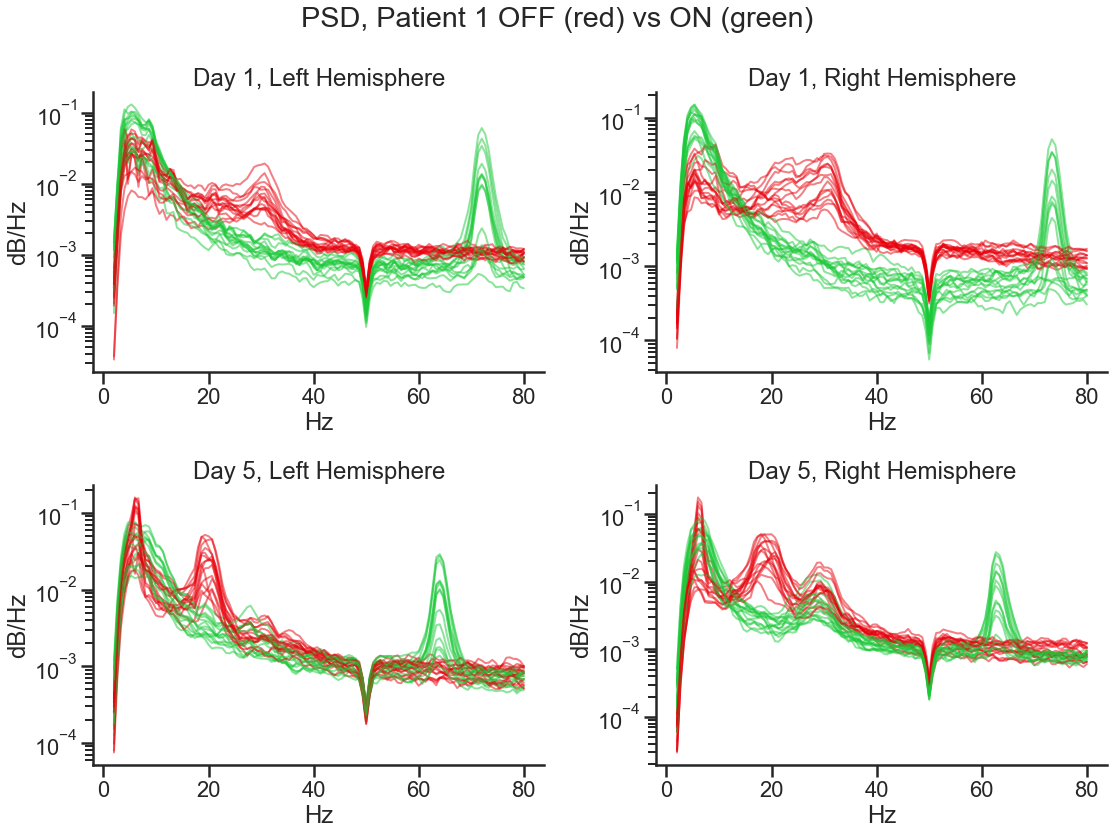

In [7]:
#%matplotlib widget
%matplotlib inline

conditions_1day_rest = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec"]
conditions_5day_rest = ["5Day OFF Rest 180sec", "5Day ON Rest 180sec"]

sf = 2000

nperseg = int(1.5 * sf)
noverlap = int(1/2 * nperseg)
welch_kwargs = {'window': 'hann', 
                'nperseg': nperseg, 
                'noverlap': noverlap, 
                'nfft': None, 
                'detrend': 'constant', 
                'scaling': 'density'}

psd_params = {'show_freqs': [2, 80], 'log': True, 'smooth': False, 'sigma': 1, 'welch_kwargs': welch_kwargs}


sns.set_context("poster")
sns.set_style("ticks")
colors = ['r', 'g']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.suptitle("PSD, Patient 1 OFF (red) vs ON (green)")

for placement in p1.placements:
    if "L" in placement:
        ax = axes[0, 0]
    if "R" in placement:
        ax = axes[0, 1]
    for i, condition in enumerate(conditions_1day_rest):
        lfp = p1.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.5, linewidth=2)
        #ax.set_ylim((0, 3))

axes[0, 0].set_title("Day 1, Left Hemisphere")
axes[0, 1].set_title("Day 1, Right Hemisphere")
#ax.set_ylim((0, 5))
sns.despine() 
#ax.legend(ncol=3)

for placement in p1.placements:
    if "L" in placement:
        ax = axes[1, 0]
    if "R" in placement:
        ax = axes[1, 1]
    for i, condition in enumerate(conditions_5day_rest):
        lfp = p1.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.5, linewidth=2)
        #ax.set_ylim((0, 15))

axes[1, 0].set_title("Day 5, Left Hemisphere")
axes[1, 1].set_title("Day 5, Right Hemisphere")
#ax.set_ylim((0, 5))
sns.despine() 
#ax.legend(ncol=3)
    
plt.tight_layout()
plt.show()

 

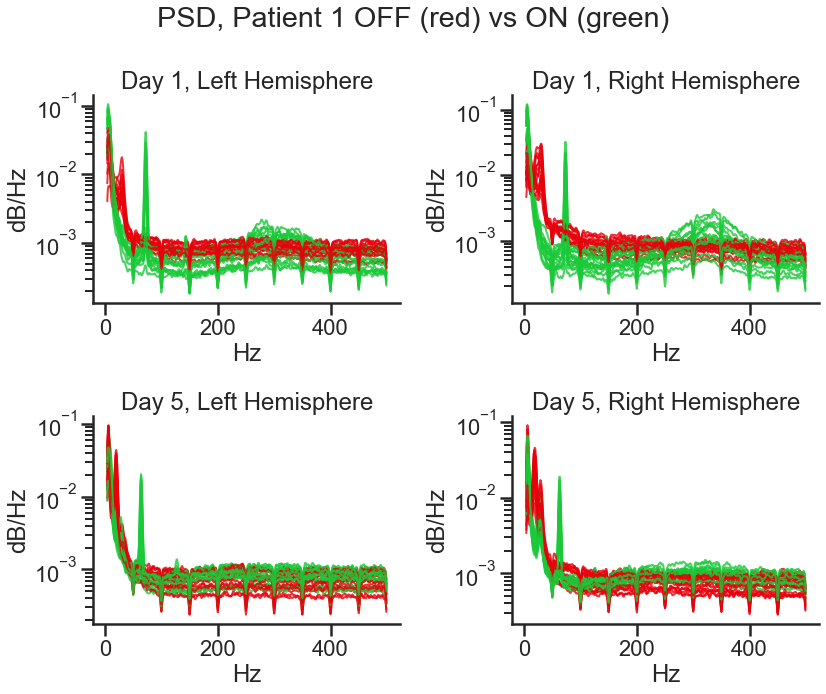

In [8]:
#%matplotlib widget
%matplotlib inline


nperseg = int(1 * sf)
noverlap = int(1/2 * nperseg)

welch_kwargs = {'window': 'hann', 
                'nperseg': nperseg, 
                'noverlap': noverlap, 
                'nfft': None, 
                'detrend': 'constant', 
                'scaling': 'density'}

psd_params = {'show_freqs': [4, 499], 'log': True, 'smooth': True, 'sigma': 1, 'welch_kwargs': welch_kwargs}


sns.set_context("poster")
sns.set_style("ticks")
colors = ['r', 'g']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.suptitle("PSD, Patient 1 OFF (red) vs ON (green)")

for placement in p1.placements:
    if "L" in placement:
        ax = axes[0, 0]
    if "R" in placement:
        ax = axes[0, 1]
    for i, condition in enumerate(conditions_1day_rest):
        lfp = p1.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.8, linewidth=2)
        #ax.set_ylim((0, 3))

axes[0, 0].set_title("Day 1, Left Hemisphere")
axes[0, 1].set_title("Day 1, Right Hemisphere")
#ax.set_ylim((1e-2, 1))
sns.despine() 
#ax.legend(ncol=3)

for placement in p1.placements:
    if "L" in placement:
        ax = axes[1, 0]
    if "R" in placement:
        ax = axes[1, 1]
    for i, condition in enumerate(conditions_5day_rest):
        lfp = p1.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.8, linewidth=2)
        #ax.set_ylim((0, 15))

axes[1, 0].set_title("Day 5, Left Hemisphere")
axes[1, 1].set_title("Day 5, Right Hemisphere")
#ax.set_ylim((1e-2, 1))
sns.despine() 
#ax.legend(ncol=3)
    
plt.tight_layout()
plt.show()

#### PAC

### Day 1, Rest: OFF vs ON

In [9]:
%matplotlib inline
# 1Day Rest OFF vs ON

sns.set(context='notebook')

conditions = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec"]

placements = []

for placement in p1.sorted_placements:
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    for j, condition in enumerate(conditions):
        lfp = p1.lfp[condition][placement]
        pac = p1.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.00025, smooth=True,
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)

### Day 5, Rest: OFF vs ON

In [10]:
# 5Day Rest OFF vs ON

sns.set(context='notebook')

conditions = ["5Day OFF Rest 180sec", "5Day ON Rest 180sec"]


for placement in p1.sorted_placements:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for j, condition in enumerate(conditions):
        lfp = p1.lfp[condition][placement]
        pac = p1.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + placement)
        #lfp.show_psd()
        comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True,
                     correction='None',
                     smooth=True,
                     vmax=0.0003,
                     ax=ax) 
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
        ax.grid(linestyle='--', alpha=0.5)
        
    plt.close(fig)
    

### Day 5 OFF Rest vs RH vs LH

In [11]:
%matplotlib inline

sns.set(context='notebook')

print(p1.name)

conditions = ["5Day OFF Rest 180sec", "5Day OFF RH Move 180sec", "5Day OFF LH Move 180sec"]

for placement in p1.sorted_placements:
    fig, axes = plt.subplots(1, len(conditions), figsize=(15, 4))
    for j, condition in enumerate(conditions):
        #lfp = p5.lfp[condition][placement]
        pac = p1.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        #print(f"Condition: {condition};\n Placement: {placement};")
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)

Patient1


### Day 5 ON Rest vs RH vs LH

In [12]:
%matplotlib inline

sns.set(context='notebook')

conditions = ["5Day ON Rest 180sec", "5Day ON RH Move 180sec", "5Day ON LH Move 180sec"]

for placement in p1.sorted_placements:
    fig, axes = plt.subplots(1, len(conditions), figsize=(15, 4))
    for j, condition in enumerate(conditions):
        #lfp = p5.lfp[condition][placement]
        pac = p1.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        #print(f"Condition: {condition};\n Placement: {placement};")
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)

## Patient 2

### Preprocessing (OPTIONAL)

In [2]:
%run p2_preprocessing.py

Succesfully imported libraries and modules

List of things to make sure before analysis: 
1) .bdf files are in patient folder (root_dir)
2) annotation files share the same name as .bdf files but with _annotations.txt suffix
3) annotations share the same naming principle: e.g. 1Day OFF RH (Com)
Looking for .bdf files in C:\Users\aleks\[[Python]]\LAB\data\Patient2
Found ['Kamalova_STN_postoper_HP_0.5Hz_1day.bdf', 'Kamalova_STN_postoper_HP_0.5Hz_5day.bdf']
Reading  Kamalova_STN_postoper_HP_0.5Hz_1day_annotations.txt
     Onset  Duration             Annotation   Day L-DOPA             State
0     90.0     180.0          1Day OFF Rest  1Day    OFF            [Rest]
1    273.0      14.0    1Day OFF LH (Com) 1  1Day    OFF    [LH, (Com), 1]
2    287.0       9.0  1Day OFF LH (NoCom) 1  1Day    OFF  [LH, (NoCom), 1]
3    356.0      14.0    1Day OFF RH (Com) 1  1Day    OFF    [RH, (Com), 1]
4    371.0      10.0  1Day OFF RH (NoCom) 1  1Day    OFF  [RH, (NoCom), 1]
5    391.0      16.0    1Day OF

Reading Channels: 100%|████████████████████████████████████████████████████████████████| 16/16 [01:29<00:00,  5.62s/it]


EEG A2-R_1-9[A2]
EEG F8-R_2C-15[F
EEG T4-R_2B-12[T
EEG T6-R_2A-10[T
EEG F4-R_3C-16[F
EEG C4-R_3B-14[C
EEG P4-R_3A-11[P
EEG O2-R_4-13[O2
EEG A1-R_1-1[A1]
EEG F7-R_2C-7[F7
EEG T3-R_2B-4[T3
EEG T5-R_2A-2[T5
EEG F3-R_3C-8[F3
EEG C3-R_3B-6[C3
EEG P3-R_3A-3[P3
EEG O1-R_4-5[O1]
Sampling frequency:  16000.0
Downsampling by the factor  8
New sampling frequency:  2000.0
Reading done, 136.9 sec
Started creating bipolar signals

R1-2C created
R1-2B created
R1-2A created
R2C-2B created
R2B-2A created
R2A-2C created
R2C-3C created
R2B-3B created
R2A-3A created
R3C-3B created
R3B-3A created
R3A-3C created
R4-3C created
R4-3B created
R4-3A created
L1-2C created
L1-2B created
L1-2A created
L2C-2B created
L2B-2A created
L2A-2C created
L2C-3C created
L2B-3B created
L2A-3A created
L3C-3B created
L3B-3A created
L3A-3C created
L4-3C created
L4-3B created
L4-3A created


Creating LFPs:   0%|          | 0/30 [00:00<?, ?it/s]

Started reading C:\Users\aleks\[[Python]]\LAB\data\Patient2\Kamalova_STN_postoper_HP_0.5Hz_1day.bdf
Channels: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


Reading Channels: 100%|████████████████████████████████████████████████████████████████| 16/16 [01:26<00:00,  5.42s/it]


EEG A2-R_1-9[A2]
EEG F8-R_2C-15[F
EEG T4-R_2B-12[T
EEG T6-R_2A-10[T
EEG F4-R_3C-16[F
EEG C4-R_3B-14[C
EEG P4-R_3A-11[P
EEG O2-R_4-13[O2
EEG A1-R_1-1[A1]
EEG F7-R_2C-7[F7
EEG T3-R_2B-4[T3
EEG T5-R_2A-2[T5
EEG F3-R_3C-8[F3
EEG C3-R_3B-6[C3
EEG P3-R_3A-3[P3
EEG O1-R_4-5[O1]
Sampling frequency:  16000.0
Downsampling by the factor  8
New sampling frequency:  2000.0
Reading done, 146.8 sec
Started creating bipolar signals

R1-2C created
R1-2B created
R1-2A created
R2C-2B created
R2B-2A created
R2A-2C created
R2C-3C created
R2B-3B created
R2A-3A created
R3C-3B created
R3B-3A created
R3A-3C created
R4-3C created
R4-3B created
R4-3A created
L1-2C created
L1-2B created
L1-2A created
L2C-2B created
L2B-2A created
L2A-2C created
L2C-3C created
L2B-3B created
L2A-3A created
L3C-3B created
L3B-3A created
L3A-3C created
L4-3C created
L4-3B created
L4-3A created


Creating LFPs:   0%|          | 0/30 [00:00<?, ?it/s]

----1Day----
------OFF------
    Onset  Duration             State
0    90.0     180.0            [Rest]
1   273.0      14.0    [LH, (Com), 1]
2   287.0       9.0  [LH, (NoCom), 1]
3   356.0      14.0    [RH, (Com), 1]
4   371.0      10.0  [RH, (NoCom), 1]
5   391.0      16.0    [LH, (Com), 2]
6   407.5      22.0  [LH, (NoCom), 2]
7   436.5      17.0    [RH, (Com), 2]
8   453.5      26.0  [RH, (NoCom), 2]
9   495.0      30.0      [LH, (Pass)]
10  535.0      30.0      [RH, (Pass)]
------ON------
     Onset  Duration             State
11  3768.0     180.0            [Rest]
12  4048.0      24.0    [RH, (Com), 1]
13  4106.0      18.0  [RH, (NoCom), 1]
14  4145.0      25.0    [RH, (Com), 2]
15  4203.0      26.0  [RH, (NoCom), 2]
16  4263.0      30.0   [RH, (Pass), 1]
17  4324.3      30.0   [RH, (Pass), 2]
18  4401.5      30.0    [LH, (Com), 1]
19  4467.5      26.0  [LH, (NoCom), 1]
20  4528.0      30.0    [LH, (Com), 2]
21  4591.0      30.0  [LH, (NoCom), 2]
22  4653.5      30.0   [LH, (Pas

### Loading Patient and PACs from pickle

In [13]:
p2 = load_patient(2)

Patient directory:  D:\LAB\AlexPAC\data\Patient2


In [16]:
p2.pac.keys()

dict_keys(['1Day OFF Rest 180sec', '1Day ON Rest 180sec', '5Day OFF LH Move 180sec', '5Day OFF Rest 180sec', '5Day OFF RH Move 180sec', '5Day ON LH Move 180sec', '5Day ON Rest 180sec', '5Day ON RH Move 180sec'])

### Disrtibution of LFP stds and maximal values

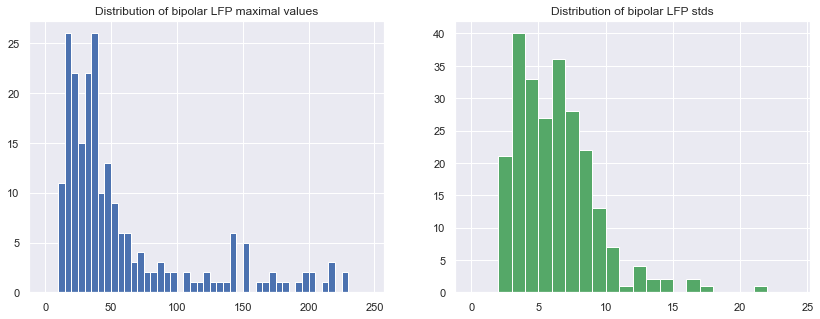

In [14]:
%matplotlib inline

max_list = []
std_list = []

for placement in p2.placements:
    for condition in p2.conditions:
        if '180sec' in condition:
            lfp = p2.lfp[condition][placement]
            max_list.append(np.max(lfp.data))
            std_list.append(np.std(lfp.data))
    
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.set_title("Distribution of bipolar LFP maximal values")      
ax.hist(max_list, bins=np.arange(0, 250, 5))

ax = axes[1]
ax.set_title("Distribution of bipolar LFP stds")      
ax.hist(std_list, bins=np.arange(0, 25, 1), color='g')
 
plt.show()

## One-electrode (diagonal) PAC

### Day 1, Rest: OFF vs ON

#### Spectra

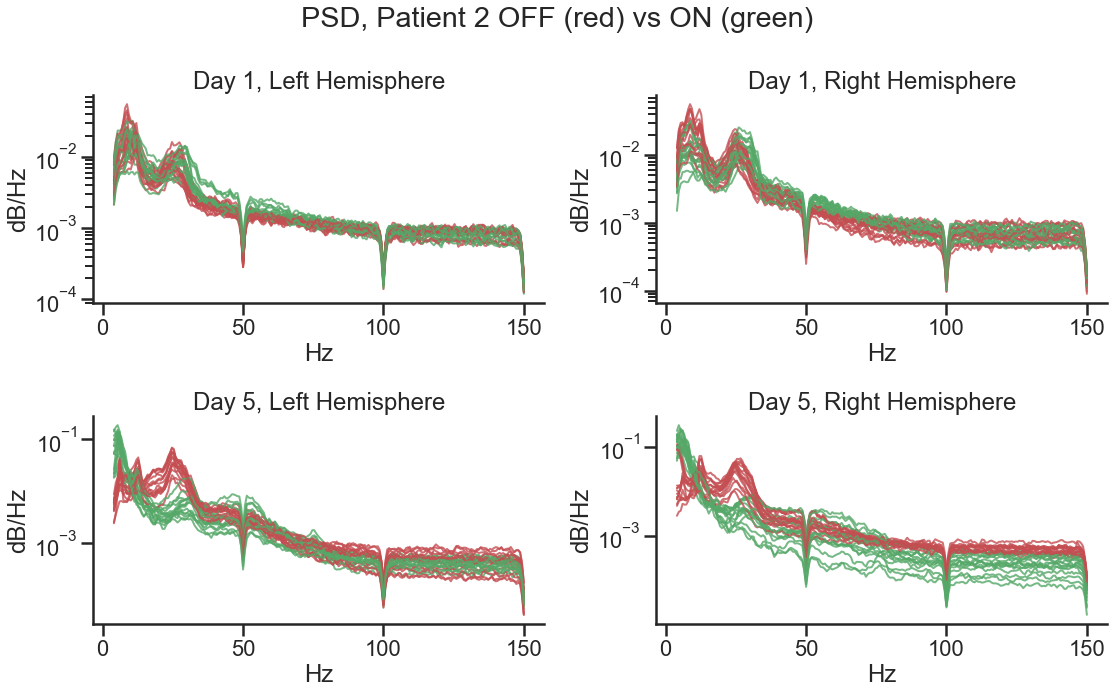

In [15]:
#%matplotlib widget
%matplotlib inline

conditions_1day_rest = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec"]
conditions_5day_rest = ["5Day OFF Rest 180sec", "5Day ON Rest 180sec"]

sf = 2000

nperseg = int(1.5 * sf)
noverlap = int(1/2 * nperseg)
welch_kwargs = {'window': 'hann', 
                'nperseg': nperseg, 
                'noverlap': noverlap, 
                'nfft': None, 
                'detrend': 'constant', 
                'scaling': 'density'}

psd_params = {'show_freqs': [4, 150], 'log': True, 'smooth': False, 'sigma': 1, 'welch_kwargs': welch_kwargs}


sns.set_context("poster")
sns.set_style("ticks")
colors = ['r', 'g']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle("PSD, Patient 2 OFF (red) vs ON (green)")

for placement in p2.placements:
    if "L" in placement:
        ax = axes[0, 0]
    if "R" in placement:
        ax = axes[0, 1]
    for i, condition in enumerate(conditions_1day_rest):
        lfp = p2.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.8, linewidth=2)
        #ax.set_ylim((0, 3))

axes[0, 0].set_title("Day 1, Left Hemisphere")
axes[0, 1].set_title("Day 1, Right Hemisphere")
#ax.set_ylim((0, 5))
sns.despine() 
#ax.legend(ncol=3)

for placement in p2.placements:
    if "L" in placement:
        ax = axes[1, 0]
    if "R" in placement:
        ax = axes[1, 1]
    for i, condition in enumerate(conditions_5day_rest):
        lfp = p2.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.8, linewidth=2)
        #ax.set_ylim((0, 15))

axes[1, 0].set_title("Day 5, Left Hemisphere")
axes[1, 1].set_title("Day 5, Right Hemisphere")
#ax.set_ylim((0, 5))
sns.despine() 
#ax.legend(ncol=3)
    
plt.tight_layout()
plt.show()

 

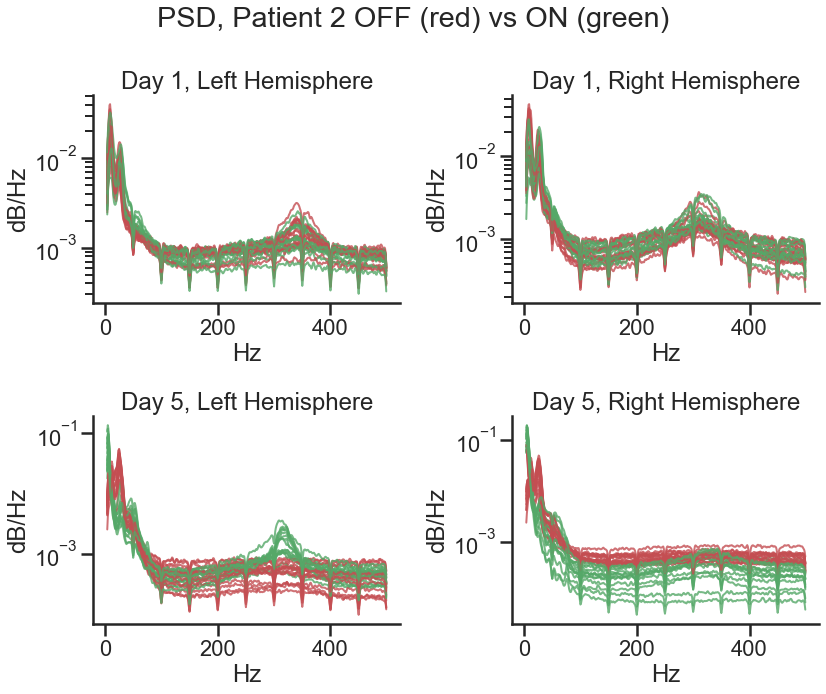

In [72]:
%matplotlib inline
#%matplotlib widget


nperseg = int(1 * sf)
noverlap = int(1/2 * nperseg)

welch_kwargs = {'window': 'hann', 
                'nperseg': nperseg, 
                'noverlap': noverlap, 
                'nfft': None, 
                'detrend': 'constant', 
                'scaling': 'density'}

psd_params = {'show_freqs': [4, 499], 'log': True, 'smooth': True, 'sigma': 1, 'welch_kwargs': welch_kwargs}


sns.set_context("poster")
colors = ['r', 'g']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.suptitle("PSD, Patient 2 OFF (red) vs ON (green)")

for placement in p2.placements:
    if "L" in placement:
        ax = axes[0, 0]
    if "R" in placement:
        ax = axes[0, 1]
    for i, condition in enumerate(conditions_1day_rest):
        lfp = p2.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.8, linewidth=2)
        #ax.set_ylim((0, 3))

axes[0, 0].set_title("Day 1, Left Hemisphere")
axes[0, 1].set_title("Day 1, Right Hemisphere")
#ax.set_ylim((1e-2, 1))
sns.despine() 
#ax.legend(ncol=3)

for placement in p2.placements:
    if "L" in placement:
        ax = axes[1, 0]
    if "R" in placement:
        ax = axes[1, 1]
    for i, condition in enumerate(conditions_5day_rest):
        lfp = p2.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.8, linewidth=2)
        #ax.set_ylim((0, 15))

axes[1, 0].set_title("Day 5, Left Hemisphere")
axes[1, 1].set_title("Day 5, Right Hemisphere")
#ax.set_ylim((1e-2, 1))
sns.despine() 
#ax.legend(ncol=3)
    
plt.tight_layout()
plt.show()

#### PAC

In [16]:
# 1Day Rest OFF vs ON

sns.set(context='notebook')

conditions = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec"]

placements = []


for placement in p2.sorted_placements:
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    for j, condition in enumerate(conditions):
        lfp = p2.lfp[condition][placement]
        pac = p2.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)

### Day 5, Rest: OFF vs ON

In [17]:
# 5Day Rest OFF vs ON

sns.set(context='notebook')

conditions = ["5Day OFF Rest 180sec", "5Day ON Rest 180sec"]


for placement in p2.sorted_placements:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for j, condition in enumerate(conditions):
        lfp = p2.lfp[condition][placement]
        pac = p2.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + placement)
        #lfp.show_psd()
        comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax) 
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
        
    plt.close(fig)
    

#### Discussion

**1 Day OFF vs ON**

*Spectrum comparison*
- PSDs look similar
- Prominent 11-13 Hz peak in OFF state, which seems to disappear in ON l-dopa state
- Very prominent 7-8 Hz peak in both states
- Beta 22-28 Hz peak in OFF state shifts to 22-35 Hz in ON state, decreases in amplitude but broadens in frequency

Question: should we allign our bipolar signal variances (amplitudes) in order for spectra to be alligned? A shifts seems to be introduced, creating a range of values typical for electrode pair and making it difficult to compare different electrode pairs.


### Day 5 OFF Rest vs RH vs LH

In [18]:
%matplotlib inline

sns.set(context='notebook')

conditions = ["5Day OFF Rest 180sec", "5Day OFF RH Move 180sec", "5Day OFF LH Move 180sec"]

for placement in p2.sorted_placements:
    fig, axes = plt.subplots(1, len(conditions), figsize=(15, 4))
    for j, condition in enumerate(conditions):
        #lfp = p5.lfp[condition][placement]
        pac = p2.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        #print(f"Condition: {condition};\n Placement: {placement};")
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)

### Day 5 ON Rest vs RH vs LH

In [19]:
%matplotlib inline

sns.set(context='notebook')

conditions = ["5Day ON Rest 180sec", "5Day ON RH Move 180sec", "5Day ON LH Move 180sec"]

for placement in p2.sorted_placements:
    fig, axes = plt.subplots(1, len(conditions), figsize=(15, 4))
    for j, condition in enumerate(conditions):
        #lfp = p5.lfp[condition][placement]
        pac = p2.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        #print(f"Condition: {condition};\n Placement: {placement};")
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)

## Patient 3

### Testing preprocessing

In [20]:
#%run patient_preprocessing.py

### Loading Patient and PACs from pickle

In [22]:
p3 = load_patient(3, load_pac=False)
p3 = copy_patient(p3)
p3.load_all_pacs(verbose=False)

Patient directory:  D:\LAB\AlexPAC\data\Patient3
List of things to make sure before analysis: 
1) .bdf files are in patient folder (root_dir)
2) annotation files share the same name as .bdf files but with _annotations.txt suffix
3) annotations share the same naming principle: e.g. 1Day OFF RH (Com)


### Observing LFPs with PAC

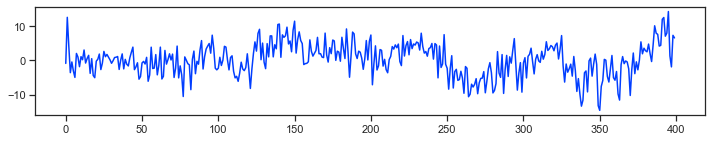

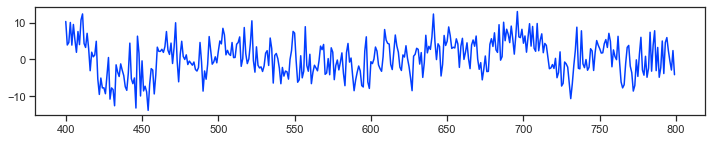

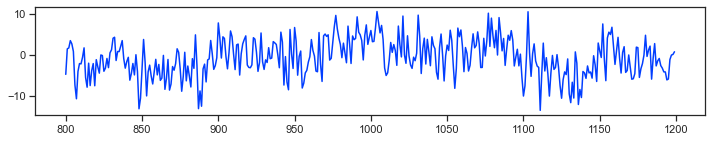

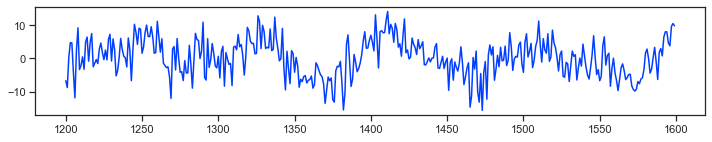

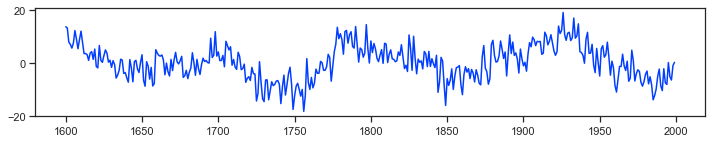

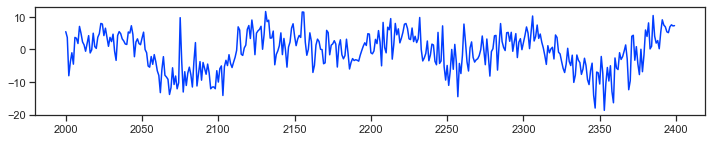

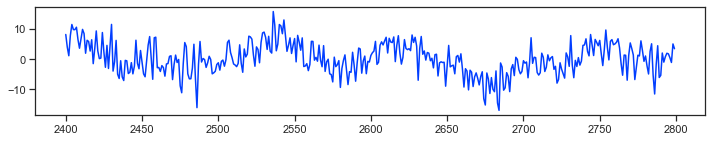

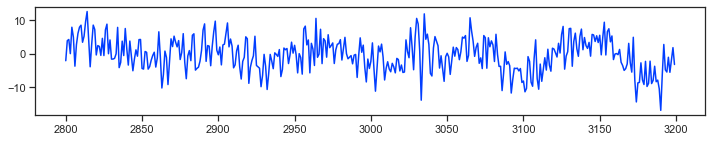

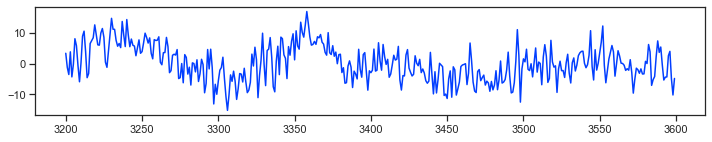

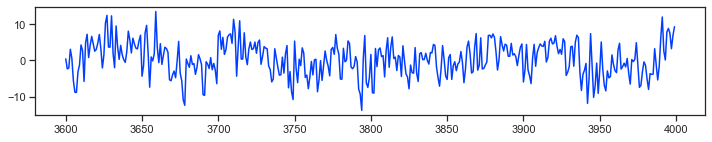

In [34]:
lfp = p3.lfp["1Day OFF Rest 180sec"]["L4-3A"]

for i in range(0, 20, 2):
    plt.figure(figsize=(12, 2))
    lfp.plot(0.1 * i, 0.1 * i + 0.2)
    plt.show()

### Disrtibution of LFP stds and maximal values

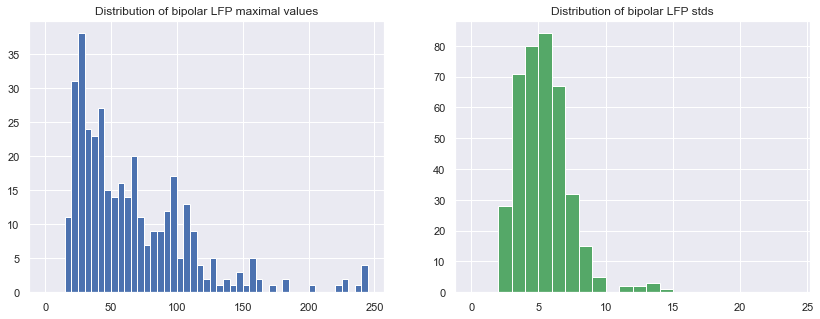

In [23]:
%matplotlib inline

max_list = []
std_list = []

for placement in p3.placements:
    for condition in p3.conditions:
        if '180sec' in condition:
            lfp = p3.lfp[condition][placement]
            max_list.append(np.max(lfp.data))
            std_list.append(np.std(lfp.data))
    
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.set_title("Distribution of bipolar LFP maximal values")      
ax.hist(max_list, bins=np.arange(0, 250, 5))

ax = axes[1]
ax.set_title("Distribution of bipolar LFP stds")      
ax.hist(std_list, bins=np.arange(0, 25, 1), color='g')

plt.show()

## One-electrode (diagonal) PAC

#### Spectra

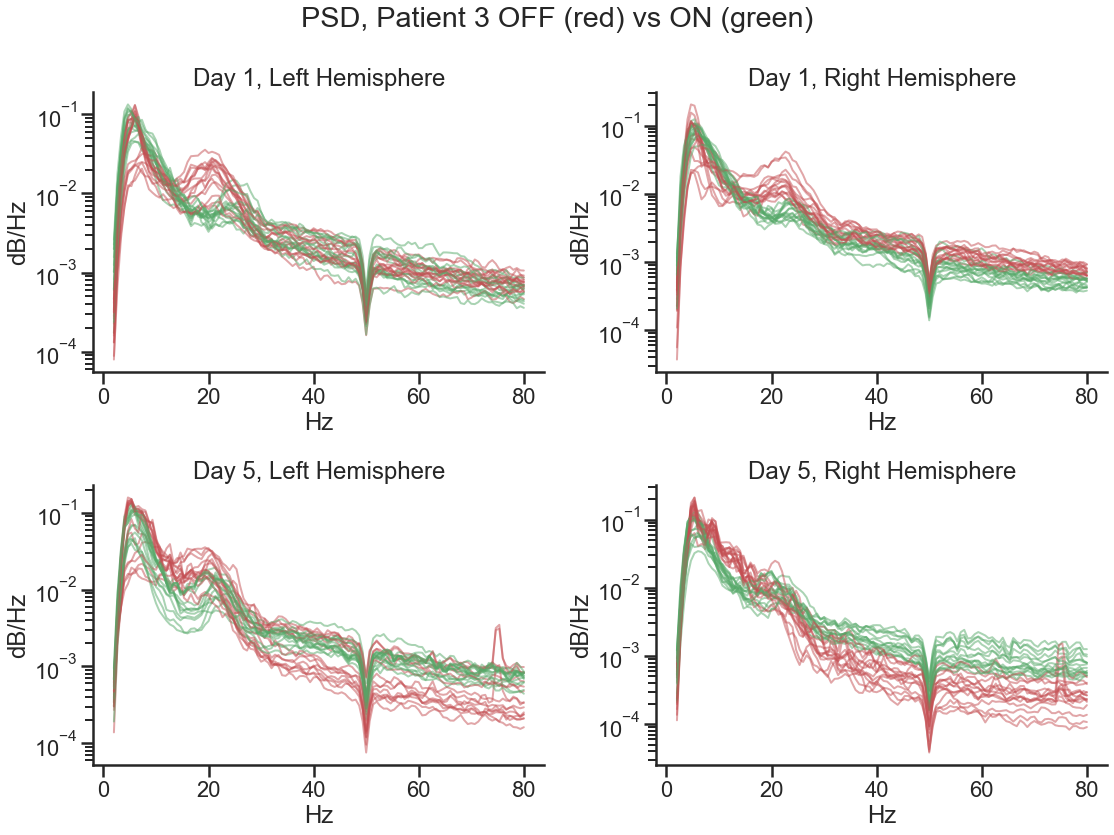

In [24]:
#%matplotlib widget
%matplotlib inline

conditions_1day_rest = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec"]
conditions_5day_rest = ["5Day OFF Rest 180sec", "5Day ON Rest 180sec"]

sf = 2000

nperseg = int(1.5 * sf)
noverlap = int(1/2 * nperseg)
welch_kwargs = {'window': 'hann', 
                'nperseg': nperseg, 
                'noverlap': noverlap, 
                'nfft': None, 
                'detrend': 'constant', 
                'scaling': 'density'}

psd_params = {'show_freqs': [2, 80], 'log': True, 'smooth': False, 'sigma': 1, 'welch_kwargs': welch_kwargs}


sns.set_context("poster")
sns.set_style("ticks")
colors = ['r', 'g']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.suptitle("PSD, Patient 3 OFF (red) vs ON (green)")

for placement in p3.placements:
    if "L" in placement:
        ax = axes[0, 0]
    if "R" in placement:
        ax = axes[0, 1]
    for i, condition in enumerate(conditions_1day_rest):
        lfp = p3.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.5, linewidth=2)
        #ax.set_ylim((0, 3))

axes[0, 0].set_title("Day 1, Left Hemisphere")
axes[0, 1].set_title("Day 1, Right Hemisphere")
#ax.set_ylim((0, 5))
sns.despine() 
#ax.legend(ncol=3)

for placement in p3.placements:
    if "L" in placement:
        ax = axes[1, 0]
    if "R" in placement:
        ax = axes[1, 1]
    for i, condition in enumerate(conditions_5day_rest):
        lfp = p3.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.5, linewidth=2)
        #ax.set_ylim((0, 15))

axes[1, 0].set_title("Day 5, Left Hemisphere")
axes[1, 1].set_title("Day 5, Right Hemisphere")
#ax.set_ylim((0, 5))
sns.despine() 
#ax.legend(ncol=3)
    
plt.tight_layout()
plt.show()

 

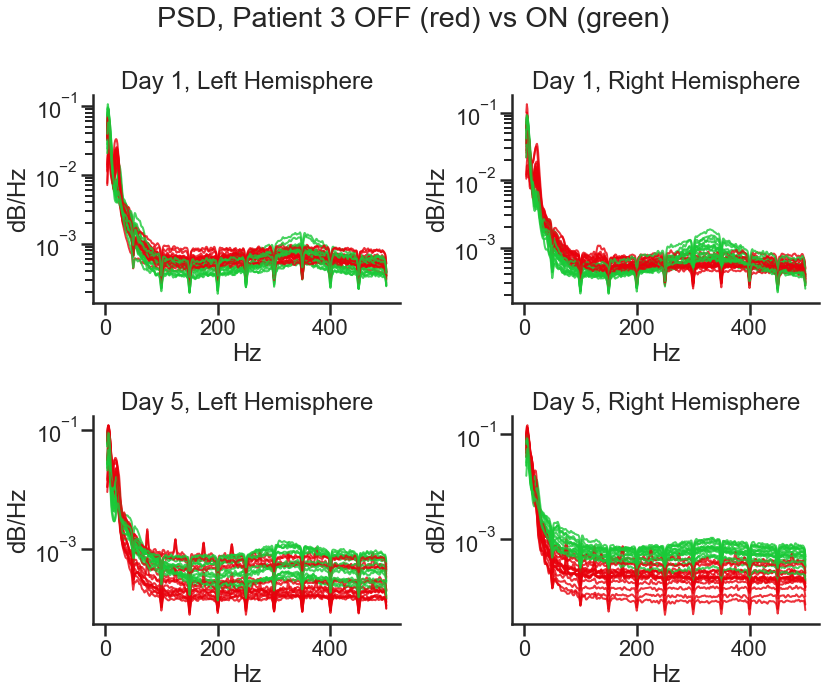

In [7]:
#%matplotlib widget
%matplotlib inline


nperseg = int(1 * sf)
noverlap = int(1/2 * nperseg)

welch_kwargs = {'window': 'hann', 
                'nperseg': nperseg, 
                'noverlap': noverlap, 
                'nfft': None, 
                'detrend': 'constant', 
                'scaling': 'density'}

psd_params = {'show_freqs': [4, 499], 'log': True, 'smooth': True, 'sigma': 1, 'welch_kwargs': welch_kwargs}


sns.set_context("poster")
sns.set_style("ticks")
colors = ['r', 'g']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.suptitle("PSD, Patient 3 OFF (red) vs ON (green)")

for placement in p3.placements:
    if "L" in placement:
        ax = axes[0, 0]
    if "R" in placement:
        ax = axes[0, 1]
    for i, condition in enumerate(conditions_1day_rest):
        lfp = p3.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.8, linewidth=2)
        #ax.set_ylim((0, 3))

axes[0, 0].set_title("Day 1, Left Hemisphere")
axes[0, 1].set_title("Day 1, Right Hemisphere")
#ax.set_ylim((1e-2, 1))
sns.despine() 
#ax.legend(ncol=3)

for placement in p3.placements:
    if "L" in placement:
        ax = axes[1, 0]
    if "R" in placement:
        ax = axes[1, 1]
    for i, condition in enumerate(conditions_5day_rest):
        lfp = p3.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.8, linewidth=2)
        #ax.set_ylim((0, 15))

axes[1, 0].set_title("Day 5, Left Hemisphere")
axes[1, 1].set_title("Day 5, Right Hemisphere")
#ax.set_ylim((1e-2, 1))
sns.despine() 
#ax.legend(ncol=3)
    
plt.tight_layout()
plt.show()

#### PAC

### Day 1, Rest: OFF vs ON

In [25]:
%matplotlib inline
# 1Day Rest OFF vs ON

sns.set(context='notebook')

conditions = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec"]

placements = []


for placement in p3.sorted_placements:
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    for j, condition in enumerate(conditions):
        lfp = p3.lfp[condition][placement]
        if not pac_exists(p3, condition, placement, placement):
            continue
        pac = p3.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)

### Day 5, Rest: OFF vs ON

In [26]:
# 5Day Rest OFF vs ON

sns.set(context='notebook')

conditions = ["5Day OFF Rest 180sec", "5Day ON Rest 180sec"]


for placement in p3.sorted_placements:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for j, condition in enumerate(conditions):
        lfp = p3.lfp[condition][placement]
        if not pac_exists(p3, condition, placement, placement):
            continue
        pac = p3.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + placement)
        #lfp.show_psd()
        comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True,
                     correction='None',
                     smooth=True,
                     vmax=0.0003,
                     ax=ax) 
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
        #ax.grid(linestyle='--', alpha=0.5)
        
    plt.close(fig)
    

### Day 1 OFF Rest vs RH vs LH

In [27]:
%matplotlib inline

sns.set(context='notebook')

print(p3.name)

conditions = ["1Day OFF Rest 180sec", "1Day OFF RH Move 180sec", "1Day OFF LH Move 180sec"]

for placement in p3.sorted_placements:
    fig, axes = plt.subplots(1, len(conditions), figsize=(15, 4))
    for j, condition in enumerate(conditions):
        #lfp = p5.lfp[condition][placement]
        if not pac_exists(p3, condition, placement, placement):
            continue
        pac = p3.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        #print(f"Condition: {condition};\n Placement: {placement};")
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)

Patient3


### Day 1 ON Rest vs RH vs LH

In [28]:
%matplotlib inline

sns.set(context='notebook')

conditions = ["1Day ON Rest 180sec", "1Day ON RH Move 180sec", "1Day ON LH Move 180sec"]

for placement in p3.sorted_placements:
    fig, axes = plt.subplots(1, len(conditions), figsize=(15, 4))
    for j, condition in enumerate(conditions):
        #lfp = p5.lfp[condition][placement]
        pac = p3.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        #print(f"Condition: {condition};\n Placement: {placement};")
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)

### Day 5 OFF Rest vs RH vs LH

In [29]:
%matplotlib inline

sns.set(context='notebook')

print(p3.name)

conditions = ["5Day OFF Rest 180sec", "5Day OFF RH Move 180sec", "5Day OFF LH Move 180sec"]

for placement in p3.sorted_placements:
    fig, axes = plt.subplots(1, len(conditions), figsize=(15, 4))
    for j, condition in enumerate(conditions):
        #lfp = p5.lfp[condition][placement]
        if not pac_exists(p3, condition, placement, placement):
            continue
        pac = p3.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        #print(f"Condition: {condition};\n Placement: {placement};")
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)

Patient3


### Day 5 ON Rest vs RH vs LH

In [30]:
%matplotlib inline

sns.set(context='notebook')

conditions = ["5Day ON Rest 180sec", "5Day ON RH Move 180sec", "5Day ON LH Move 180sec"]

for placement in p3.sorted_placements:
    fig, axes = plt.subplots(1, len(conditions), figsize=(15, 4))
    for j, condition in enumerate(conditions):
        #lfp = p5.lfp[condition][placement]
        pac = p3.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        #print(f"Condition: {condition};\n Placement: {placement};")
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)

## Patient 4

### Preprocessing (OPTIONAL)

In [44]:
#%run preprocessing.py

### Loading Patient and PACs from pickle

In [45]:
p4 = load_patient(4)

Patient directory:  D:\LAB\AlexPAC\data\Patient4


In [46]:
p4.pac.keys()

dict_keys(['1Day OFF LH Move 180sec', '1Day OFF Rest 180sec', '1Day OFF RH Move 180sec', '1Day ON LH Move 180sec', '1Day ON Rest 180sec', '1Day ON RH Move 180sec', '5Day OFF LH Move 180sec', '5Day OFF Rest 180sec', '5Day OFF RH Move 180sec', '5Day ON LH Move 180sec', '5Day ON Rest 180sec', '5Day ON RH Move 180sec'])

### Distribution of LFP stds and maximal values

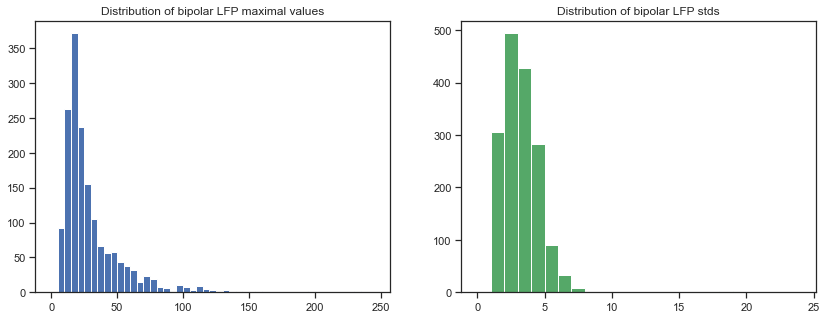

In [47]:
%matplotlib inline

sns.set_style('ticks')

max_list = []
std_list = []

for placement in p4.placements:
    for condition in p4.conditions:
        lfp = p4.lfp[condition][placement]
        max_list.append(np.max(lfp.data))
        std_list.append(np.std(lfp.data))
    
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.set_title("Distribution of bipolar LFP maximal values")      
ax.hist(max_list, bins=np.arange(0, 250, 5))

ax = axes[1]
ax.set_title("Distribution of bipolar LFP stds")      
ax.hist(std_list, bins=np.arange(0, 25, 1), color='g')

plt.show()

## One-electrode (diagonal) PAC

### Iterating through LFPs once again to remove extra 50Hz harmonics

In [48]:
for placement in p4.placements:
    for condition in p4.conditions:
        if ('180sec' in condition) and ('L' in placement):
            lfp = p4.lfp[condition][placement]
            lfp.remove_50hz_harmonics(50, inplace=True)

In [49]:
p4.save()

Saving Patient4 object to D:\LAB\AlexPAC\data\Patient4\Patient4.pkl ...
Pickling Patient4 without ['pac']
Done, 2.4364423751831055 sec
File size: 2330.316354751587 MB
Returning filepath for saved file


'D:\\LAB\\AlexPAC\\data\\Patient4\\Patient4.pkl'

### Day 1, Rest: OFF vs ON

#### Spectra

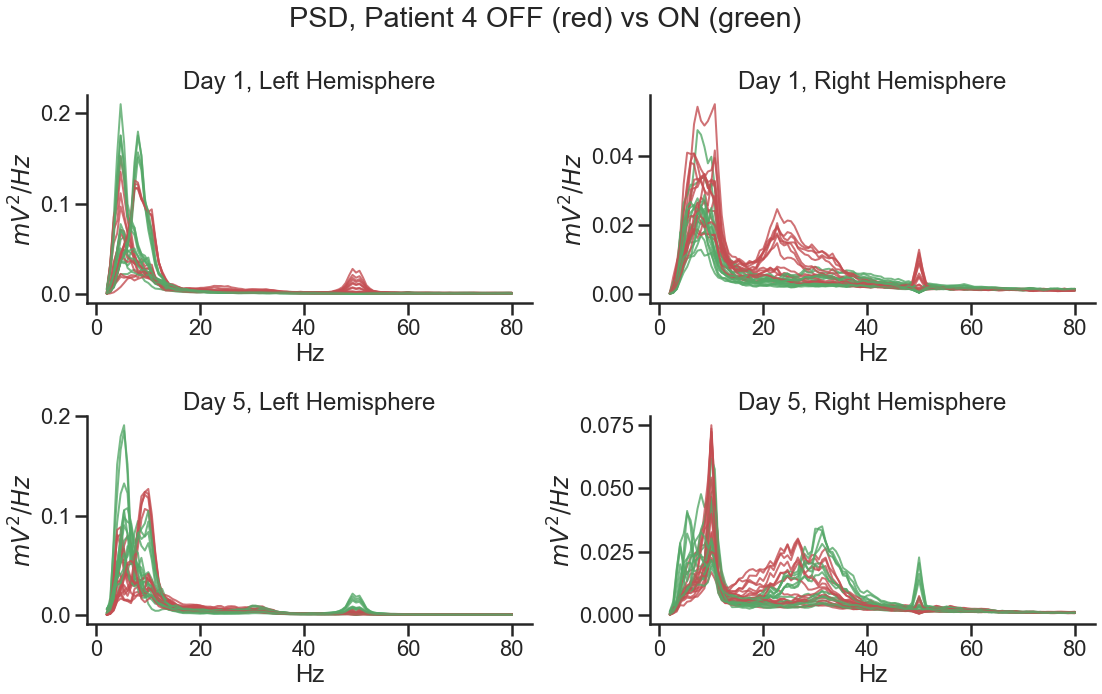

In [50]:
#%matplotlib widget
%matplotlib inline

conditions_1day_rest = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec"]
conditions_5day_rest = ["5Day OFF Rest 180sec", "5Day ON Rest 180sec"]

sf = 2000

nperseg = int(1.5 * sf)
noverlap = int(1/2 * nperseg)
welch_kwargs = {'window': 'hann', 
                'nperseg': nperseg, 
                'noverlap': noverlap, 
                'nfft': None, 
                'detrend': 'constant', 
                'scaling': 'density'}

psd_params = {'show_freqs': [2, 80], 'log': False, 'smooth': False, 'sigma': 1, 'welch_kwargs': welch_kwargs}


sns.set_context("poster")
sns.set_style("ticks")
colors = ['r', 'g']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle("PSD, Patient 4 OFF (red) vs ON (green)")

for placement in p4.placements:
    if "L" in placement:
        ax = axes[0, 0]
    if "R" in placement:
        ax = axes[0, 1]
    for i, condition in enumerate(conditions_1day_rest):
        lfp = p4.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.8, linewidth=2)
        #ax.set_ylim((0, 3))

axes[0, 0].set_title("Day 1, Left Hemisphere")
axes[0, 1].set_title("Day 1, Right Hemisphere")
#ax.set_ylim((0, 5))
sns.despine() 
#ax.legend(ncol=3)

for placement in p4.placements:
    if "L" in placement:
        ax = axes[1, 0]
    if "R" in placement:
        ax = axes[1, 1]
    for i, condition in enumerate(conditions_5day_rest):
        lfp = p4.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.8, linewidth=2)
        #ax.set_ylim((0, 15))

axes[1, 0].set_title("Day 5, Left Hemisphere")
axes[1, 1].set_title("Day 5, Right Hemisphere")
#ax.set_ylim((0, 5))
sns.despine() 
#ax.legend(ncol=3)
    
plt.tight_layout()
plt.show()

 

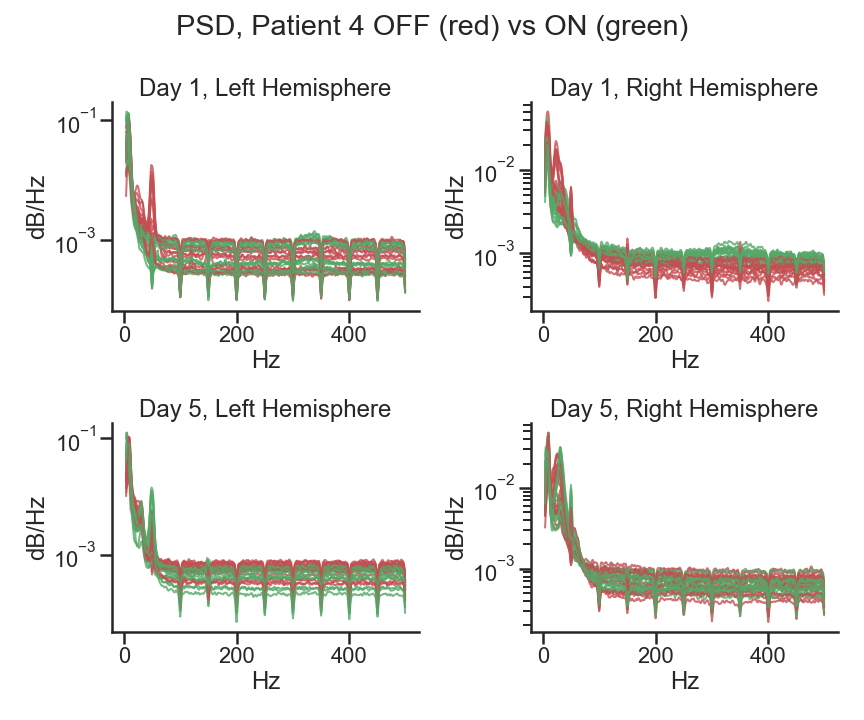

In [51]:
#%matplotlib widget
%matplotlib widget


nperseg = int(1 * sf)
noverlap = int(1/2 * nperseg)

welch_kwargs = {'window': 'hann', 
                'nperseg': nperseg, 
                'noverlap': noverlap, 
                'nfft': None, 
                'detrend': 'constant', 
                'scaling': 'density'}

psd_params = {'show_freqs': [4, 499], 'log': True, 'smooth': True, 'sigma': 1, 'welch_kwargs': welch_kwargs}


sns.set_context("poster")
colors = ['r', 'g']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.suptitle("PSD, Patient 4 OFF (red) vs ON (green)")

for placement in p4.placements:
    if "L" in placement:
        ax = axes[0, 0]
    if "R" in placement:
        ax = axes[0, 1]
    for i, condition in enumerate(conditions_1day_rest):
        lfp = p4.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.8, linewidth=2)
        #ax.set_ylim((0, 3))

axes[0, 0].set_title("Day 1, Left Hemisphere")
axes[0, 1].set_title("Day 1, Right Hemisphere")
#ax.set_ylim((1e-2, 1))
sns.despine() 
#ax.legend(ncol=3)

for placement in p4.placements:
    if "L" in placement:
        ax = axes[1, 0]
    if "R" in placement:
        ax = axes[1, 1]
    for i, condition in enumerate(conditions_5day_rest):
        lfp = p4.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.8, linewidth=2)
        #ax.set_ylim((0, 15))

axes[1, 0].set_title("Day 5, Left Hemisphere")
axes[1, 1].set_title("Day 5, Right Hemisphere")
#ax.set_ylim((1e-2, 1))
sns.despine() 
#ax.legend(ncol=3)
    
plt.tight_layout()
plt.show()

#### PAC

In [52]:
# 1Day Rest OFF vs ON

%matplotlib inline

sns.set(context='notebook')

conditions = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec"]


for placement in p4.sorted_placements:
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    for j, condition in enumerate(conditions):
        lfp = p4.lfp[condition][placement]
        pac = p4.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        #print(f"Condition: {condition};\n Placement: {placement};")
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)

### Day 5 Rest OFF vs ON

In [53]:
# 5Day Rest OFF vs ON

sns.set(context='notebook')

conditions = ["5Day OFF Rest 180sec", "5Day ON Rest 180sec"]


for placement in p4.sorted_placements:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for j, condition in enumerate(conditions):
        lfp = p4.lfp[condition][placement]
        pac = p4.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + placement)
        #lfp.show_psd()
        comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax) 
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
        
    plt.close(fig)
    

### Day 1 OFF Rest vs RH vs LH

In [54]:
%matplotlib inline

sns.set(context='notebook')

conditions = ["1Day OFF Rest 180sec", "1Day OFF RH Move 180sec", "1Day OFF LH Move 180sec"]

for placement in p4.sorted_placements:
    fig, axes = plt.subplots(1, len(conditions), figsize=(15, 4))
    for j, condition in enumerate(conditions):
        #lfp = p4.lfp[condition][placement]
        pac = p4.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        #print(f"Condition: {condition};\n Placement: {placement};")
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)

### Day 1 ON Rest vs RH vs LH

In [55]:
%matplotlib inline

sns.set(context='notebook')

conditions = ["1Day ON Rest 180sec", "1Day ON RH Move 180sec", "1Day ON LH Move 180sec"]

for placement in p4.sorted_placements:
    fig, axes = plt.subplots(1, len(conditions), figsize=(15, 4))
    for j, condition in enumerate(conditions):
        #lfp = p4.lfp[condition][placement]
        pac = p4.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        #print(f"Condition: {condition};\n Placement: {placement};")
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)

## Patient 5

### Preprocessing (OPTIONAL)

In [20]:
#%run p5_preprocessing.py

### Loading Patient and PACs from pickle

In [34]:
p5 = load_patient(5)

Patient directory:  D:\LAB\AlexPAC\data\Patient5


### Distribution of LFP stds and maximal values

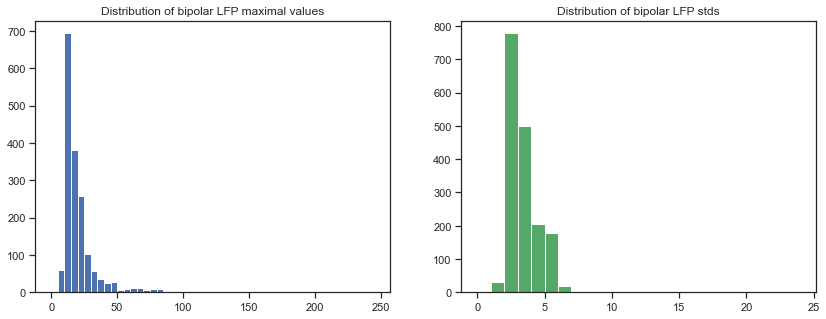

In [35]:
%matplotlib inline

sns.set_style('ticks')

max_list = []
std_list = []

for placement in p5.placements:
    for condition in p5.conditions:
        lfp = p5.lfp[condition][placement]
        max_list.append(np.max(lfp.data))
        std_list.append(np.std(lfp.data))
    
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.set_title("Distribution of bipolar LFP maximal values")      
ax.hist(max_list, bins=np.arange(0, 250, 5))

ax = axes[1]
ax.set_title("Distribution of bipolar LFP stds")      
ax.hist(std_list, bins=np.arange(0, 25, 1), color='g')

plt.show()

## One-electrode (diagonal) PAC

### Day 1, Rest: OFF vs ON

#### Spectra

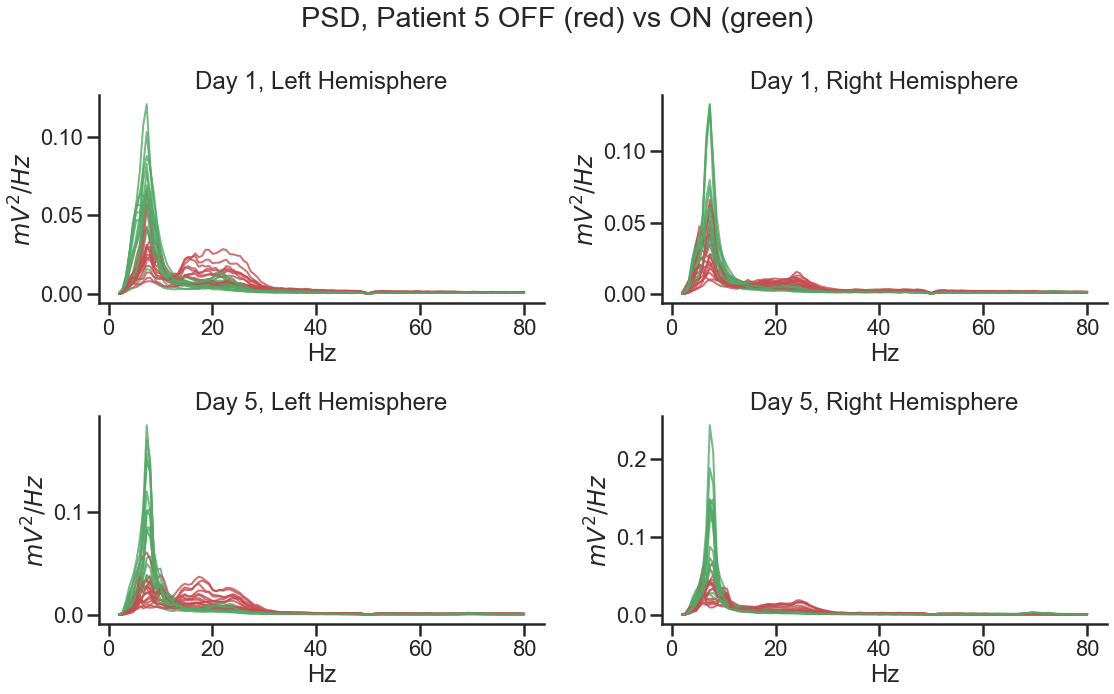

In [36]:
#%matplotlib widget
%matplotlib inline

conditions_1day_rest = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec"]
conditions_5day_rest = ["5Day OFF Rest 180sec", "5Day ON Rest 180sec"]

sf = 2000

nperseg = int(1.5 * sf)
noverlap = int(1/2 * nperseg)
welch_kwargs = {'window': 'hann', 
                'nperseg': nperseg, 
                'noverlap': noverlap, 
                'nfft': None, 
                'detrend': 'constant', 
                'scaling': 'density'}

psd_params = {'show_freqs': [2, 80], 'log': False, 'smooth': False, 'sigma': 1, 'welch_kwargs': welch_kwargs}


sns.set_context("poster")
sns.set_style("ticks")
colors = ['r', 'g']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle("PSD, Patient 5 OFF (red) vs ON (green)")

for placement in p5.placements:
    if "L" in placement:
        ax = axes[0, 0]
    if "R" in placement:
        ax = axes[0, 1]
    for i, condition in enumerate(conditions_1day_rest):
        lfp = p5.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.8, linewidth=2)
        #ax.set_ylim((0, 3))

axes[0, 0].set_title("Day 1, Left Hemisphere")
axes[0, 1].set_title("Day 1, Right Hemisphere")
#ax.set_ylim((0, 5))
sns.despine() 
#ax.legend(ncol=3)

for placement in p5.placements:
    if "L" in placement:
        ax = axes[1, 0]
    if "R" in placement:
        ax = axes[1, 1]
    for i, condition in enumerate(conditions_5day_rest):
        lfp = p5.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.8, linewidth=2)
        #ax.set_ylim((0, 15))

axes[1, 0].set_title("Day 5, Left Hemisphere")
axes[1, 1].set_title("Day 5, Right Hemisphere")
#ax.set_ylim((0, 5))
sns.despine() 
#ax.legend(ncol=3)
    
plt.tight_layout()
plt.show()

 

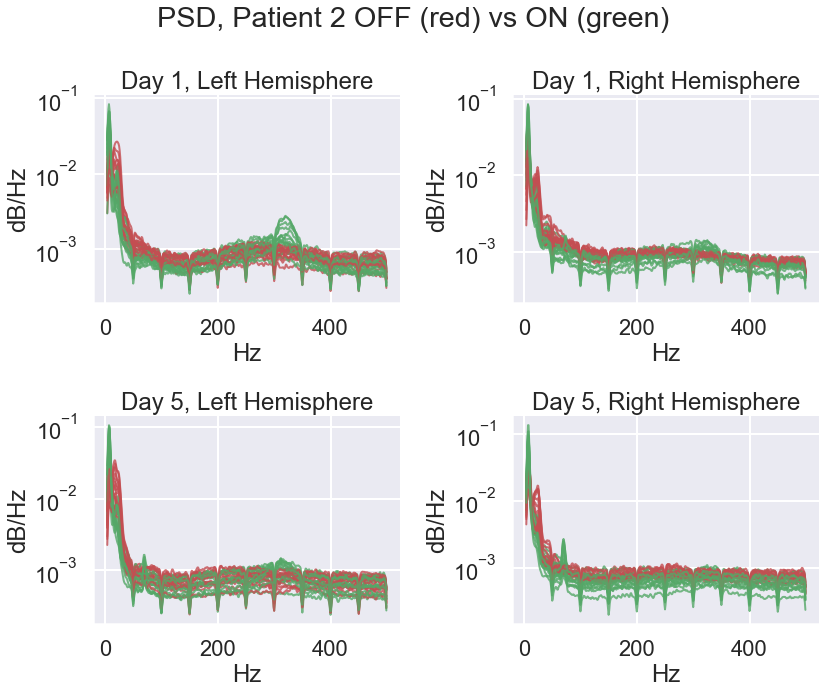

In [42]:
#%matplotlib widget
%matplotlib inline


nperseg = int(1 * sf)
noverlap = int(1/2 * nperseg)

welch_kwargs = {'window': 'hann', 
                'nperseg': nperseg, 
                'noverlap': noverlap, 
                'nfft': None, 
                'detrend': 'constant', 
                'scaling': 'density'}

psd_params = {'show_freqs': [4, 499], 'log': True, 'smooth': True, 'sigma': 1, 'welch_kwargs': welch_kwargs}


sns.set_context("poster")
colors = ['r', 'g']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.suptitle("PSD, Patient 2 OFF (red) vs ON (green)")

for placement in p5.placements:
    if "L" in placement:
        ax = axes[0, 0]
    if "R" in placement:
        ax = axes[0, 1]
    for i, condition in enumerate(conditions_1day_rest):
        lfp = p5.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.8, linewidth=2)
        #ax.set_ylim((0, 3))

axes[0, 0].set_title("Day 1, Left Hemisphere")
axes[0, 1].set_title("Day 1, Right Hemisphere")
#ax.set_ylim((1e-2, 1))
sns.despine() 
#ax.legend(ncol=3)

for placement in p5.placements:
    if "L" in placement:
        ax = axes[1, 0]
    if "R" in placement:
        ax = axes[1, 1]
    for i, condition in enumerate(conditions_5day_rest):
        lfp = p5.lfp[condition][placement]
        new_lfp = lfp.copy()
        new_lfp.data /= new_lfp.data.std()
        new_lfp.show_psd(ax=ax, **psd_params, color=colors[i], alpha=0.8, linewidth=2)
        #ax.set_ylim((0, 15))

axes[1, 0].set_title("Day 5, Left Hemisphere")
axes[1, 1].set_title("Day 5, Right Hemisphere")
#ax.set_ylim((1e-2, 1))
sns.despine() 
#ax.legend(ncol=3)
    
plt.tight_layout()
plt.show()

#### PAC

In [38]:
# 1Day Rest OFF vs ON

%matplotlib inline

sns.set(context='notebook')

conditions = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec"]


for placement in p5.sorted_placements:
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    for j, condition in enumerate(conditions):
        lfp = p5.lfp[condition][placement]
        pac = p5.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        #print(f"Condition: {condition};\n Placement: {placement};")
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)

In [43]:
# 5Day Rest OFF vs ON

sns.set(context='notebook')

conditions = ["5Day OFF Rest 180sec", "5Day ON Rest 180sec"]


for placement in p5.sorted_placements:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for j, condition in enumerate(conditions):
        lfp = p5.lfp[condition][placement]
        pac = p5.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + placement)
        #lfp.show_psd()
        comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax) 
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
        
    plt.close(fig)
    

### Day 1 OFF Rest vs RH vs LH

In [40]:
%matplotlib inline

sns.set(context='notebook')

conditions = ["1Day OFF Rest 180sec", "1Day OFF RH Move 180sec", "1Day OFF LH Move 180sec"]

for placement in p5.sorted_placements:
    fig, axes = plt.subplots(1, len(conditions), figsize=(15, 4))
    for j, condition in enumerate(conditions):
        #lfp = p5.lfp[condition][placement]
        pac = p5.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        #print(f"Condition: {condition};\n Placement: {placement};")
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)

### Day 1 ON Rest vs RH vs LH

In [41]:
%matplotlib inline

sns.set(context='notebook')

conditions = ["1Day ON Rest 180sec", "1Day ON RH Move 180sec", "1Day ON LH Move 180sec"]

for placement in p5.sorted_placements:
    fig, axes = plt.subplots(1, len(conditions), figsize=(15, 4))
    for j, condition in enumerate(conditions):
        #lfp = p5.lfp[condition][placement]
        pac = p5.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        #print(f"Condition: {condition};\n Placement: {placement};")
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.0003, 
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)

## Patient 6

### Day 1, Rest: OFF vs ON

In [31]:
p6 = load_patient(6)

Patient directory:  D:\LAB\AlexPAC\data\Patient6


In [32]:
%matplotlib inline
# 1Day Rest OFF vs ON

sns.set(context='notebook')

conditions = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec"]

placements = []

for placement in p6.sorted_placements:
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    for j, condition in enumerate(conditions):
        lfp = p6.lfp[condition][placement]
        pac = p6.pac[condition][placement][placement]
        ax = axes[j]
        ax.set_title(condition + '; ' + placement)
        #lfp.show_psd()
        im = comodulogram(pac.pac_matrix.copy(), 
                     pac.beta_params, 
                     pac.hfo_params, 
                     pvalues=pac.pvalues, 
                     significant=True, 
                     vmax=0.00025, smooth=True,
                     ax=ax)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        ax.grid()
    plt.tight_layout()
    plt.close(fig)